In [92]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import savgol_filter

In [93]:
from summer2 import CompartmentalModel, Stratification, Multiply
from summer2.parameters import Parameter
from summer2.functions import get_piecewise_scalar_function

In [94]:
def pcwise_temp(x,domain,breakpts,vals):
    y = np.empty_like(x)
    num_intervals = len(breakpts)+1
    masks = []
    m = (domain[0] <= x) & (x <= breakpts[0])
    masks.append(m)
    for i in range(1,num_intervals-1):
        m = (breakpts[i-1] < x) & (x <= breakpts[i])
        masks.append(m)
    m = (breakpts[len(breakpts)-1] < x) & (x <= domain[1])
    masks.append(m)
    for j in range(0,num_intervals):
        y[masks[j]] = vals[j]
    return y

def pcwise_fcn(domain,breakpts,vals):
    def f(x):
        y = pcwise_temp(x,domain,breakpts,vals)
        return y 
    return f

In [95]:
#Plot piecewise function
domain = [0,10]
breakpts = [2,7]
vals = [1,2,3]
f = pcwise_fcn(domain,breakpts,vals)
xlist = np.linspace(domain[0], domain[1], num = 1000)
ylist = f(xlist)
fig = go.Figure()
fig = fig.add_trace(go.Scatter(x = xlist, y=ylist, name = "f"))
fig.show()

**Model 2: SEIQR (Stratified Infectious Compartment)**

In [96]:
def generate_transmission_parameter(num_breakpts):
    breakpts = []
    s = Parameter("len_pd"+str(1))
    breakpts.append(s)
    for i in range(2,num_breakpts+1):
        s += Parameter("len_pd"+str(i))
        breakpts.append(s)
    rates = []
    r = Parameter("rate"+str(1))
    rates.append(r)
    for k in range(2,num_breakpts+2):
        r = r*Parameter("multiplier"+str(k))
        rates.append(r)
    return breakpts, rates

In [97]:
def generate_default_breakpts_and_rates(times,num_breakpts):
    time_length = times[1] - times[0]
    subinterval_length = time_length / (num_breakpts + 1)
    defp = {}
    for i in range(1,num_breakpts+1):
        defp["len_pd"+str(i)] = 0.9*subinterval_length
        defp["multiplier"+str(i+1)] = 1.0
    return defp

In [98]:
def generate_transmission_priors(times,num_breakpts):
    time_length = times[1] - times[0]
    subinterval_length = time_length / (num_breakpts + 1)
    priors = [esp.UniformPrior("rate1",(0,1))]
    for i in range(1,num_breakpts+1):
        priors.append(esp.UniformPrior("len_pd"+str(i),(0,1.5*subinterval_length)))
        #prior for len_pd might need adjustments
        priors.append(esp.UniformPrior("multiplier"+str(i+1),(0.5,1.5)))
    return priors
    

In [99]:
def build_model(num_breakpts):
    #num_breakpts = number of breakpts for pcwise constant effective transmission rate parameter
    m = CompartmentalModel(
    times=[0, 274],
    compartments=["S", "E1", "E2", "E3", "E4", "I1", "I2", "I3", "I4", "Q1", "Q2", "Q3", "Q4", "R"],
    infectious_compartments=["I1", "I2", "I3", "I4"],
    timestep = 1,
    ref_date=datetime(2020,4,1)
    )
    m.set_initial_population({"S": 10353498.0, "E1": 360.0 , "I1": 544.0})
    #We set up a piecewise constant "effective contact rate"
    breakpts, rates = generate_transmission_parameter(num_breakpts)
    m.add_infection_frequency_flow("infection", get_piecewise_scalar_function(breakpts, rates),"S","E1") 
    #Progression rate for wild-type strain is 1/6.65 (Yu Wu et al.), which is multiplied by 4 because of the chained E compartmens
    m.add_transition_flow("progression1", 0.6,"E1","E2")
    m.add_transition_flow("progression2", 0.6,"E2","E3")
    m.add_transition_flow("progression3", 0.6,"E3","E4")
    m.add_transition_flow("progression4", 0.6,"E4","I1")
    #Detection can happen from any of the I compartments
    m.add_transition_flow("notification1", Parameter("detection_rate"),"I1","Q1")
    m.add_transition_flow("notification2", Parameter("detection_rate"),"I2","Q2")
    m.add_transition_flow("notification3", Parameter("detection_rate"),"I3","Q3")
    m.add_transition_flow("notification4", Parameter("detection_rate"),"I4","Q4")
    #Progression along I1 -> I2 -> I3 -> I4 -> R or Q1 -> Q2 -> Q3 -> Q4 -> R is governed by a single parameter tau, which corresponds to the mean duration of infectiousness
    #Due to the chained compartments, each transition flow has a rate of 4/tau.
    #Action point: Below is the assumption for now but this should be updated after checking relevant lit.
    tau = 14.0 
    m.add_transition_flow("I1_to_I2", 4/tau,"I1","I2") 
    m.add_transition_flow("I2_to_I3", 4/tau,"I2","I3") 
    m.add_transition_flow("I3_to_I4", 4/tau,"I3","I4") 
    m.add_transition_flow("I4_to_R", 4/tau,"I4","R") 
    m.add_transition_flow("Q1_to_Q2", 4/tau,"Q1","Q2") 
    m.add_transition_flow("Q2_to_Q3", 4/tau,"Q2","Q3") 
    m.add_transition_flow("Q3_to_Q4", 4/tau,"Q3","Q4") 
    m.add_transition_flow("Q4_to_R", 4/tau,"Q4","R") 
    #No death dynamics for now since they are quite minimal at this point and data might not be accurate
    #Action point: Revisit this later to see if it needs updating    
    #m.add_death_flow("infection_death", Parameter("death_rate"), "I")
    #
    #Requesting Outputs
    m.request_output_for_flow("notification1", "notification1")
    m.request_output_for_flow("notification2", "notification2")
    m.request_output_for_flow("notification3", "notification3")
    m.request_output_for_flow("notification4", "notification4")
    m.request_aggregate_output(name = "notifications", sources=["notification1", "notification2", "notification3", "notification4"], save_results=True)
    #m.request_output_for_flow("infection_death", "infection_death")
    #m.request_cumulative_output(name="deaths_cumulative", source="infection_death")
    #
    #Action point: Incorporate age stratification  
    return m

In [100]:
num_breakpts = 10
m = build_model(num_breakpts)
m.get_input_parameters()

/var/folders/58/qy67y27x0jsd0h0bx4dmp2yw0000gn/T/ipykernel_89160/3948066976.py:13: DeprecationWarning:

This method is deprecated and scheduled for removal, use get_piecewise_function instead



{'detection_rate',
 'len_pd1',
 'len_pd10',
 'len_pd2',
 'len_pd3',
 'len_pd4',
 'len_pd5',
 'len_pd6',
 'len_pd7',
 'len_pd8',
 'len_pd9',
 'multiplier10',
 'multiplier11',
 'multiplier2',
 'multiplier3',
 'multiplier4',
 'multiplier5',
 'multiplier6',
 'multiplier7',
 'multiplier8',
 'multiplier9',
 'rate1'}

In [101]:
defp_breakpts_rates = generate_default_breakpts_and_rates([m.times.min(),m.times.max()], num_breakpts)
parameters = {
    "rate1": 0.15, 
    "detection_rate": 0.1}
parameters.update(defp_breakpts_rates)

In [102]:
parameters

{'rate1': 0.15,
 'detection_rate': 0.1,
 'len_pd1': 22.418181818181818,
 'multiplier2': 1.0,
 'len_pd2': 22.418181818181818,
 'multiplier3': 1.0,
 'len_pd3': 22.418181818181818,
 'multiplier4': 1.0,
 'len_pd4': 22.418181818181818,
 'multiplier5': 1.0,
 'len_pd5': 22.418181818181818,
 'multiplier6': 1.0,
 'len_pd6': 22.418181818181818,
 'multiplier7': 1.0,
 'len_pd7': 22.418181818181818,
 'multiplier8': 1.0,
 'len_pd8': 22.418181818181818,
 'multiplier9': 1.0,
 'len_pd9': 22.418181818181818,
 'multiplier10': 1.0,
 'len_pd10': 22.418181818181818,
 'multiplier11': 1.0}

In [103]:
m.run(parameters)

In [104]:
fig = px.line(m.get_outputs_df())
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [105]:
fig = px.line(m.get_derived_outputs_df())
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Targets**

In [106]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
notification_data = df["NOTIFICATIONS"]
#death_data = df["CUMULATIVE DEATHS"]

In [107]:
notification_smoothed = savgol_filter(notification_data, window_length=12, polyorder=2)
notification_smoothed = pd.DataFrame(notification_smoothed, index=notification_data.keys())
notification_smoothed = notification_smoothed.rename(columns={0:'smoothed_data'})
notification_smoothed = notification_smoothed['smoothed_data']

In [108]:
fig = px.line(notification_data)
fig = fig.add_trace(go.Scatter(x = notification_smoothed.keys(), y=notification_smoothed, name = "smoothed"))
fig.show()

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [109]:
notification_target = notification_smoothed[31::2]
#death_data_cal = death_data[:90:2]

In [110]:
fig = px.scatter(notification_target)
fig.show()
#death_data_cal.plot(style='.')

/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



**Optimization**

In [111]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [112]:
# Import nevergrad
import nevergrad as ng

# Import our convenience wrapper
from estival.wrappers.nevergrad import optimize_model

In [113]:
targets = [
    #est.NormalTarget("notification", notification_data_cal, np.std(notification_data_cal) * 0.1)
    est.TruncatedNormalTarget("notifications", notification_target, (0.0,np.inf),
        esp.UniformPrior("notification_dispersion",(0.1, notification_target.max()*0.1))),
    #est.NormalTarget("deaths_cumulative", death_data_cal, np.std(death_data_cal) * 0.1)
]

In [114]:
transmission_priors = generate_transmission_priors([m.times.min(),m.times.max()],num_breakpts)

priors = [
    esp.UniformPrior("detection_rate", (0,0.5)),
] + transmission_priors

In [115]:
priors

[UniformPrior detection_rate {bounds: (0.0, 0.5)},
 UniformPrior rate1 {bounds: (0.0, 1.0)},
 UniformPrior len_pd1 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier2 {bounds: (0.5, 1.5)},
 UniformPrior len_pd2 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier3 {bounds: (0.5, 1.5)},
 UniformPrior len_pd3 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier4 {bounds: (0.5, 1.5)},
 UniformPrior len_pd4 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier5 {bounds: (0.5, 1.5)},
 UniformPrior len_pd5 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier6 {bounds: (0.5, 1.5)},
 UniformPrior len_pd6 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier7 {bounds: (0.5, 1.5)},
 UniformPrior len_pd7 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier8 {bounds: (0.5, 1.5)},
 UniformPrior len_pd8 {bounds: (0.0, 37.36363636363637)},
 UniformPrior multiplier9 {bounds: (0.5, 1.5)},
 UniformPrior len_pd9 {bounds: (0.0, 37.36363636363637)},
 

In [116]:
defp = parameters

In [117]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)

In [118]:
# TwoPointsDE is a good suggested default for some of our typical use cases
opt_class = ng.optimizers.TwoPointsDE
orunner = optimize_model(bcm, opt_class=opt_class)

In [119]:
# You can also suggest starting points for the optimization (as well as specify an init method for unsuggested points)
# This is the "midpoint" method by default (ie the 0.5 ppf of the prior distribution)
orunner = optimize_model(bcm, opt_class=opt_class, suggested=defp, init_method="midpoint")

In [120]:
# Here we run the optimizer in a loop, inspecting the current best point at each iteration
# Using the loss information at each step can provide the basis for stopping conditions

for i in range(8):
    # Run the minimizer for a specified 'budget' (ie number of evaluations)
    rec = orunner.minimize(800)
    # Print the loss (objective function value) of the current recommended parameters
    print(rec.loss)

48.434693775131
48.15216392787015
47.91018502223916
47.69469235967554
47.69469235967554
47.69469235967554
47.653988107048875
47.653988107048875


In [121]:
mle_params = rec.value[1]
mle_params

{'detection_rate': 0.29439509049191837,
 'rate1': 0.31626730078584625,
 'len_pd1': 20.515923201635538,
 'multiplier2': 0.9505255438375807,
 'len_pd2': 25.157452879643618,
 'multiplier3': 1.4304762385429055,
 'len_pd3': 17.430112173232015,
 'multiplier4': 1.3344546632350816,
 'len_pd4': 11.0695679660327,
 'multiplier5': 0.8028653228221306,
 'len_pd5': 26.671565139514644,
 'multiplier6': 1.0520942918344371,
 'len_pd6': 21.419142330946052,
 'multiplier7': 0.5937775719461829,
 'len_pd7': 12.455244552613156,
 'multiplier8': 0.9245563698560864,
 'len_pd8': 26.13734860377816,
 'multiplier9': 0.8490644516899079,
 'len_pd9': 13.697748115785462,
 'multiplier10': 1.2374903163992967,
 'len_pd10': 14.510510447025876,
 'multiplier11': 0.9978925416178298,
 'notification_dispersion': 215.66038885748253}

In [122]:
# Run the model against the parameter estimates
res = bcm.run(mle_params)

In [126]:
#Generate breakpts and rates for mle
breakpts = []
s = mle_params["len_pd"+str(1)]
breakpts.append(s)
for i in range(2,num_breakpts+1):
    s += mle_params["len_pd"+str(i)]
    breakpts.append(s)
rates = []
r = mle_params["rate"+str(1)]
rates.append(r)
for k in range(2,num_breakpts+2):
    r = r*mle_params["multiplier"+str(k)]
    rates.append(r)

print(breakpts)
print(rates)

#Plot "effective contact rate"
domain = [m.times.min(),m.times.max()]
dates = res.derived_outputs.notifications.keys()
f = pcwise_fcn(domain,breakpts,rates)
xlist = np.linspace(domain[0], domain[1], num = len(dates))
ylist = f(xlist)
fig = go.Figure()
fig = fig.add_trace(go.Scatter(x = dates, y=ylist, name = "eff. contact rate"))
fig.add_vrect(x0="2020-04-01", x1="2020-05-16", 
              annotation_text="ECQ", annotation_position="top left",
              fillcolor="aqua", opacity=0.25, line_width=0)
fig.add_vrect(x0="2020-05-16", x1="2020-06-01", 
              annotation_text="MECQ", annotation_position="top left",
              fillcolor="pink", opacity=0.25, line_width=0)
fig.add_vrect(x0="2020-06-01", x1="2020-08-03", 
              annotation_text="GCQ", annotation_position="top left",
              fillcolor="lightgreen", opacity=0.25, line_width=0)
fig.add_vrect(x0="2020-08-03", x1="2020-08-19", 
              annotation_text="MECQ", annotation_position="top left",
              fillcolor="pink", opacity=0.25, line_width=0)
fig.add_vrect(x0="2020-08-19", x1="2020-12-31", 
              annotation_text="GCQ", annotation_position="top left",
              fillcolor="lightgreen", opacity=0.25, line_width=0)
fig.show()

[20.515923201635538, 45.67337608127916, 63.10348825451118, 74.17305622054388, 100.84462136005853, 122.26376369100458, 134.71900824361774, 160.8563568473959, 174.55410496318135, 189.0646154102072]
[0.31626730078584625, 0.3006201480775102, 0.43002997865212805, 0.5738555103432148, 0.46072868956496366, 0.48473002437565865, 0.28782181692319264, 0.26610749421989005, 0.22594241367038626, 0.2796015489809871, 0.27901230035291935]


In [124]:
target = "notifications"

fig = go.Figure()
fig = fig.add_trace(go.Scatter(x = res.derived_outputs[target].keys(), y = res.derived_outputs[target], name = "MLE"))
fig = fig.add_trace(go.Scatter(x = bcm.targets[target].data.keys(), y = bcm.targets[target].data, name = "data", marker = dict(color='orange')))
fig.show()

-0.025210910817325453


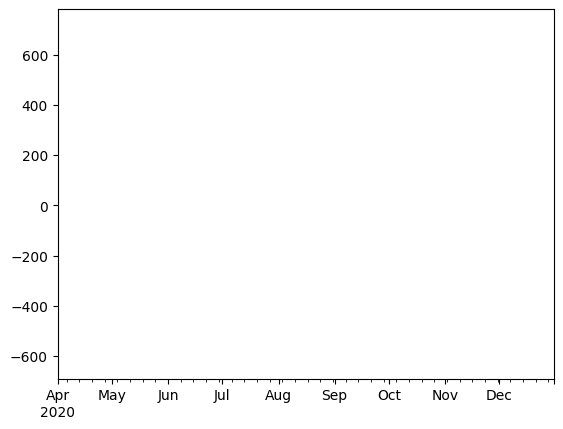

In [125]:
# Inspect the bias of the resulting output

diff = (res.derived_outputs[target] - bcm.targets[target].data)
print(diff.mean() / diff.std())
diff.plot();